# Travelling Salesman Problem: #

In [86]:
"""Environment for Travelling Salesman Problem."""

from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np


class TSP(gym.Env):
    """Traveling Salesman Problem (TSP) RL environment for persistent monitoring.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets in the least number of steps, with rewards determined by the distance traveled.
    """

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = 7) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Max Square area where the targets are defined. Defaults to 30
            seed (int, optional): Random seed for reproducibility. Defaults to None.
        """
        super().__init__()
        if seed is not None:
            np.random.seed(seed=7)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        # Observation Space : {current loc (loc), dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0

        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(
        self, action: int
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        points = []
        # Generate n random 2D points within the 10x10 grid
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        """Calculate the distance matrix between all target locations.

        Args:
            locations (List): List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            past_loc (int): Previous location of the agent.
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -10000
        return reward



### Defining the various methods

In [87]:
import numpy as np
import random

class ValueIteration:
    def __init__(self, env, gamma=0.9, theta=1e-4):
        """
        Initialize the Value Iteration algorithm.

        Args:
            env: The TSP environment.
            gamma (float): Discount factor for future rewards. Defaults to 0.9.
            theta (float): Convergence threshold. Defaults to 1e-4.
        """
        self.env = env
        self.gamma = gamma
        self.theta = theta

        self.num_targets = self.env.num_targets
        self.value_table = np.zeros(self.num_targets)  # Initialize value table
        self.policy = np.zeros(self.num_targets, dtype=int)  # Initialize policy to zeros

    def run_value_iteration(self):
        """
        Perform the value iteration algorithm.

        Returns:
            value_table (np.ndarray): The converged value table.
            policy (np.ndarray): The optimal policy for each state.
        """
        while True:
            delta = 0  # check for convergence
            for state in range(self.num_targets):
                v = self.value_table[state]
                best_action, best_value = self._find_best_action(state)
                self.value_table[state] = best_value
                self.policy[state] = best_action
                delta = max(delta, abs(v - best_value))

            if delta < self.theta:  # Stop if converges
                break

        return self.value_table, self.policy

    def _find_best_action(self, state):
        """
        Find the best action from a given state by considering all possible actions.

        Args:
            state (int): The current state (target).

        Returns:
            best_action (int): The action that maximizes expected return.
            best_value (float): The expected return of taking the best action.
        """
        best_action = None
        best_value = float('-inf')

        for action in range(self.num_targets):
            # Avoid self-loops by penalty
            if action == state:
                continue

            # Perform a one-step lookahead
            reward = -self.env.distances[state, action]
            action_value = reward + self.gamma * self.value_table[action]

            if action_value > best_value:
                best_value = action_value
                best_action = action

        return best_action, best_value
    
class MonteCarlo:
    def __init__(self, env, gamma=0.9, num_episodes=1000):
        """
        Initialize the Monte Carlo algorithm.

        Args:
            env: The TSP environment.
            gamma (float): Discount factor. Defaults to 0.9.
            num_episodes (int): Number of episodes to run. Defaults to 1000.
        """
        self.env = env
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.value_table = np.zeros(self.env.num_targets)  # Value table for each state
        self.policy = np.zeros(self.env.num_targets, dtype=int)  # Policy for each state
        self.state_action_count = {}  # To count state-action pairs for averaging
        self.returns = {}  #  store returns for state-action pairs

    def run_first_visit(self):
        """Run Monte Carlo First Visit algorithm."""
        for episode in range(self.num_episodes):
            self.env.reset()
            episode_data = []  # To store (state, action, reward)
            done = False

            while not done:
                state = self.env.loc
                action = self.env.action_space.sample()  # Random action for exploring starts
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode_data.append((state, action, reward))
                done = terminated or truncated

            # Calculate returns and update value table
            self._update_first_visit(episode_data)

        return self.value_table, self.policy

    def run_every_visit(self):
        """Run Monte Carlo Every Visit algorithm."""
        for episode in range(self.num_episodes):
            self.env.reset()
            episode_data = []  # To store (state, action, reward)
            done = False

            while not done:
                state = self.env.loc
                action = self.env.action_space.sample()  # Random action for exploring starts
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode_data.append((state, action, reward))
                done = terminated or truncated

            # Calculate returns and update value table
            self._update_every_visit(episode_data)

        return self.value_table, self.policy

    def _update_first_visit(self, episode_data):
        """Update values for first visit Monte Carlo."""
        visited = set()
        G = 0

        # Calculate returns in reverse order
        for state, action, reward in reversed(episode_data):
            G = reward + self.gamma * G
            if (state, action) not in visited:
                visited.add((state, action))
                if (state, action) not in self.returns:
                    self.returns[(state, action)] = []
                self.returns[(state, action)].append(G)
                self.value_table[state] = np.mean(self.returns[(state, action)])

    def _update_every_visit(self, episode_data):
        """Update values for every visit Monte Carlo."""
        G = 0

        # Calculate returns in reverse order
        for state, action, reward in reversed(episode_data):
            G = reward + self.gamma * G
            if (state, action) not in self.returns:
                self.returns[(state, action)] = []
            self.returns[(state, action)].append(G)
            self.value_table[state] = np.mean(self.returns[(state, action)])

    def extract_policy(self):
        """Extract the optimal policy from the value table."""
        for state in range(self.env.num_targets):
            best_action = None
            best_value = float('-inf')
            for action in range(self.env.num_targets):
                if (state, action) in self.returns:
                    action_value = np.mean(self.returns[(state, action)])
                    if action_value > best_value:
                        best_value = action_value
                        best_action = action
            self.policy[state] = best_action



### Plot function

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_policy_circular(policy, num_targets, ax, title):
    """
    Plot the policy as a circular directed network graph.

    Args:
        policy (np.ndarray): The policy to plot.
        num_targets (int): The number of targets.
        ax: The axes to plot on.
        title (str): Title for the plot.
    """
    G = nx.DiGraph()

    # Add nodes
    for i in range(num_targets):
        G.add_node(i)

    # Add edges
    for state in range(num_targets):
        action = policy[state]
        G.add_edge(state, action)

    # Draw graph
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax, with_labels=True, arrows=True, node_color='lightblue', node_size=2000, font_size=16)

    # edge labels
    edge_labels = {(state, policy[state]): f'{policy[state]}' for state in range(num_targets)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', ax=ax)

    ax.set_title(title)

## Main body

In [89]:

if __name__ == "__main__":
    
    num_targets = 50
    env = TSP(num_targets)

    #value iteration
    vi = ValueIteration(env)

    # Run
    vi_optimal_value_table, vi_policy = vi.run_value_iteration()

    # results 
    print("Optimal Value Table(using value iteration):")
    print(vi_optimal_value_table)

    print("\nOptimal Policy:(using value iteration)")
    print(vi_policy)
 


Optimal Value Table(using value iteration):
[-13.7630595   -5.06431152 -17.98199227 -17.90490352  -7.63474097
  -9.9392231  -18.05266276  -9.11408634  -8.89493206 -21.58899813
 -10.14374102  -8.72473362 -20.30457551  -5.55390131 -12.84987574
  -8.79846899  -9.07643969  -6.60200363 -16.79811196 -13.6619082
 -11.66531945 -14.50763983  -5.19070667  -7.57799474 -11.58776241
 -10.31008797 -12.1067977  -18.43425528 -13.03618679  -6.61058721
 -15.4974412  -12.75359548 -13.66192963 -17.8955289  -15.12981481
 -20.30460736  -7.90960644 -13.81616704 -11.14917414 -12.01863821
  -9.82492447  -3.88222802 -14.40452159  -3.88223411 -14.93117525
 -14.39730019 -15.45200249  -7.63475294 -13.25910944 -11.99527075]

Optimal Policy:(using value iteration)
[24 41 34 32 47 13 39 17 47 12 43  4 35 43 26  4 36 41 21 32 25 14  1 41
 41 16 29  6 49 43 44 38 19 45 42 12 47 14 40 36  8 43 37 41 48  5  0  4
 13 11]


In [90]:
if __name__ == "__main__":

    num_targets = 50
    env = TSP(num_targets)
    # monte carlo
    mc_agent = MonteCarlo(env, num_episodes=1000)

    #  First Visit mc
    value_table_first_visit, policy_first_visit = mc_agent.run_first_visit()
    mc_agent.extract_policy()

    # results
    print("Monte Carlo First Visit Optimal Value Table:")
    print(value_table_first_visit)
    print("\nMonte Carlo First Visit Optimal Policy:")
    print(policy_first_visit)

Monte Carlo First Visit Optimal Value Table:
[-26218.0609598  -35111.07056011 -30575.17036049 -39101.66931075
 -32288.87925502 -37395.62080564 -35281.17310158 -36531.54830262
 -35518.58292338 -34300.4647763  -30428.71044157 -36006.29975012
 -39651.20934724 -34318.88661623 -37289.51481419 -30880.90502856
 -37697.44061498 -32647.46784125 -33301.63388834 -29046.5867703
 -32646.43333341 -33877.76132059 -36931.77480456 -35959.65499274
 -29900.87762873 -35255.60326589 -33953.01452928 -34703.59088104
 -31042.73502956 -34303.62380122 -33582.92786195 -36378.75913327
 -35108.25023155 -32762.70551298 -36208.5233523  -36625.86700823
 -34981.87679622 -35396.34627001 -31823.19441731 -36744.9215646
 -31126.64831386 -34290.27621038 -32555.56954418 -29964.80807692
 -35603.41995162 -35727.20247589 -35236.39031034 -30019.95473955
 -36968.68823094 -33928.78006649]

Monte Carlo First Visit Optimal Policy:
[17 16  8 11  2 37 37 45  1 27 46 39  6 45  9 16 14 33 32 18 18 20 10 25
 29 16 17 17 47 27 15  7 46  

In [91]:
if __name__ == "__main__":

    num_targets = 50
    env = TSP(num_targets)
    
    # Reset and run Every Visit mc
    mc_agent = MonteCarlo(env, num_episodes=1000)
    value_table_every_visit, policy_every_visit = mc_agent.run_every_visit()
    mc_agent.extract_policy()

    # results
    print("\nMonte Carlo Every Visit Optimal Value Table:")
    print(value_table_every_visit)
    print("\nMonte Carlo Every Visit Optimal Policy:")
    print(policy_every_visit)



Monte Carlo Every Visit Optimal Value Table:
[-22339.38224013 -27228.33181638 -32069.87322509 -39490.14775902
 -36020.37691406 -37385.09799726 -29590.08946117 -39230.51329731
 -36116.28678296 -35608.41252633 -38256.98280572 -37856.62144975
 -34491.50223076 -34643.66636781 -27840.43652949 -33569.09934817
 -36690.87421907 -36550.85888273 -30174.62845789 -31491.46200383
 -42355.95809998 -37681.16952393 -28484.34012371 -32507.06787588
 -36743.64136855 -36865.95308959 -39071.55544053 -33490.42119182
 -33336.99125618 -35248.43567615 -34998.38238753 -36855.48602441
 -31767.66465733 -31487.82138222 -38157.13014718 -33873.56837784
 -38251.36613017 -38512.4182202  -32556.51651901 -36360.66182544
 -37707.9483537  -34492.79009682 -37539.53099442 -37961.17987821
 -33981.64559619 -33686.06676225 -35287.78058629 -35144.40445267
 -36448.18366793 -31947.8659719 ]

Monte Carlo Every Visit Optimal Policy:
[13 47 27 40 26  1  2 22 34 40 37 39  1 23  5 13  6 25  8 32  3 32 27 45
 13 44 13 18  3 23 38  4 1

Circular plots to demonstrate optimal policy of each method


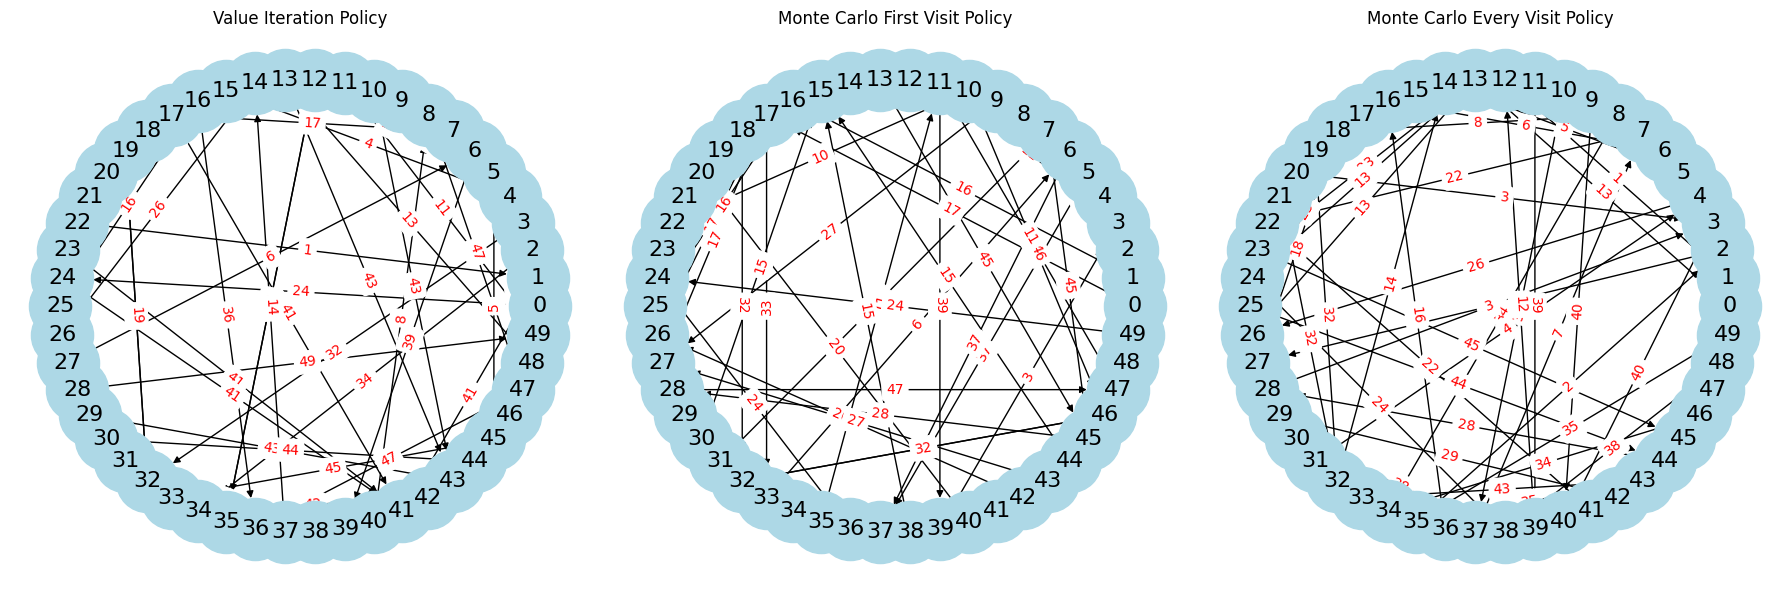

In [92]:
print("Circular plots to demonstrate optimal policy of each method")
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_policy_circular(vi_policy, num_targets, axs[0], "Value Iteration Policy")
plot_policy_circular(policy_first_visit, num_targets, axs[1], "Monte Carlo First Visit Policy")
plot_policy_circular(policy_every_visit, num_targets, axs[2], "Monte Carlo Every Visit Policy")


plt.tight_layout()
plt.show()
